In [1]:
! pip install git+https://www.github.com/keras-team/keras-contrib.git
! pip install seqeval
! pip install sklearn_crfsuite

import pandas as pd 
import numpy as np
from math import nan
from future.utils import iteritems
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.model_selection import train_test_split

#loading train data
from google.colab import drive
drive.mount('/content/drive')
df=pd.read_csv('/content/drive//My Drive/entity_train.csv')

df1=df[['type','Sentence ID','Text','Semantic Type']]

df1=df1[df1['type']=='entity']  #We take only the entities i.e. removing the text and relation types

df1=df1[['Sentence ID','Text','Semantic Type']]

df1=df1.rename(columns={'Sentence ID':'sentence_idx','Text':'word','Semantic Type':'tag'})

#loading test data
from google.colab import drive
drive.mount('/content/drive')
dftest=pd.read_csv('/content/drive//My Drive/entity_test.csv')

dftest1=dftest[['type','Sentence ID','Text','Semantic Type']]

dftest1=dftest1[dftest1['type']=='entity']  #We take only the entities i.e. removing the text and relation

dftest1=dftest1[['Sentence ID','Text','Semantic Type']]

dftest1=dftest1.rename(columns={'Sentence ID':'sentence_idx','Text':'word','Semantic Type':'tag'})

###creating sentence id

#for train data

index_train=df1.index


seq_train=[]
seq_train.append(df1['sentence_idx'][index_train[0]])
for i in range(1,len(index_train)):
  seq_train.append(df1['sentence_idx'][index_train[i]]-df1['sentence_idx'][index_train[i-1]])
len(seq_train)


neg_ind_train=[]
for i in range(len(seq_train)):
  if seq_train[i]<0:
    seq_train[i]=1
    neg_ind_train.append(i)

df1=df1.assign(ind_train=seq_train)
sen_id=df1['ind_train'].cumsum()
df1=df1.assign(sentence_idx=sen_id)
df1=df1.drop('ind_train',1)
df1=df1.dropna()

#creating sentence id for test data

index_test=dftest1.index


seq_test=[]
seq_test.append(dftest1['sentence_idx'][index_test[0]])
for i in range(1,len(index_test)):
  seq_test.append(dftest1['sentence_idx'][index_test[i]]-dftest1['sentence_idx'][index_test[i-1]])
len(seq_test)


neg_ind_test=[]
for i in range(len(seq_test)):
  if seq_test[i]<0:
    seq_test[i]=1
    neg_ind_test.append(i)

dftest1=dftest1.assign(ind_test=seq_test)
sen_id=dftest1['ind_test'].cumsum()
dftest1=dftest1.assign(sentence_idx=sen_id)
dftest1=dftest1.drop('ind_test',1)
dftest1=dftest1.dropna()

import random
random.seed(123)
sample01=random.sample(list(dftest1.sentence_idx.unique()),10000)

s_ind=[]
for i in dftest1.index:
  if dftest1.sentence_idx[i] in sample01:
    s_ind.append(i)

dftest1=dftest1.loc[s_ind]

#Split test data into 2 half
test_sp1, test_sp2 = train_test_split(dftest1, test_size=0.5,random_state=123)

dftest_sp1=test_sp1.sort_index(axis = 0)	# sort by index labels
dfdev1, test_sp = train_test_split(test_sp2, test_size=0.5,random_state=123)	#Split other half test data into dev and test data
dfdev1=dfdev1.sort_index(axis=0)
test_sp=test_sp.sort_index(axis=0)
dftest1=test_sp

#Taking only required tags and the rest renamed as others 'O'
tag_req=['diap','fndg','lbpr','lbtr']
df2=df1[df1.tag.str.contains('|'.join(tag_req))]

req_train=df2.index

for i in df1.index:
  if i not in req_train:
    df1.tag[i]='O'
  else:
    if ',' in df1.tag[i]:
      df1.tag[i]='O'

dftest2=dftest1[dftest1.tag.str.contains('|'.join(tag_req))]

req_test=dftest2.index

for i in dftest1.index:
  if i not in req_test:
    dftest1.tag[i]='O'
  else:
    if ',' in dftest1.tag[i]:
      dftest1.tag[i]='O'

dfdev2=dfdev1[dfdev1.tag.str.contains('|'.join(tag_req))]

req_dev=dfdev2.index

for i in dfdev1.index:
  if i not in req_dev:
    dfdev1.tag[i]='O'
  else:
    if ',' in dfdev1.tag[i]:
      dfdev1.tag[i]='O'

dftest_sp2=dftest_sp1[dftest_sp1.tag.str.contains('|'.join(tag_req))]

req_test_sp=dftest_sp2.index

for i in dftest_sp1.index:
  if i not in req_test_sp:
    dftest_sp1.tag[i]='O'
  else:
    if ',' in dftest_sp1.tag[i]:
      dftest_sp1.tag[i]='O'

#BIO-tagging For Train Data
temp01=pd.DataFrame(df1.word.str.split().tolist(), index=df1['sentence_idx']).stack()
d1 = temp01.index
t1 = []
for i in range(len(d1)):
  if d1[i][1] == 0:
    t1.append('B-')
  else:
    t1.append('I-')
temp01 = temp01.reset_index()[[0, 'sentence_idx']] # 'word' variable is currently labeled 0
temp01.columns = ['word','sentence_idx']
temp01=temp01[['sentence_idx','word']]
temp01=temp01.assign(bio_tr=t1)

temp02=pd.DataFrame(df1.word.str.split().tolist(), index=df1['tag']).stack()
temp02 = temp02.reset_index()[[0, 'tag']] # 'word' variable is currently labeled 0
temp02.columns = ['word','tag']

temp01["tag"] = temp01["bio_tr"].astype(str) + temp02["tag"]
del temp01['bio_tr']
temp01['tag']=temp01['tag'].replace(['B-O','I-O'],'O')

df1=temp01

#BIO-tagging For Test Data
temp_test01=pd.DataFrame(dftest1.word.str.split().tolist(), index=dftest1['sentence_idx']).stack()
d1_test = temp_test01.index
t1_test = []
for i in range(len(d1_test)):
  if d1_test[i][1] == 0:
    t1_test.append('B-')
  else:
    t1_test.append('I-')
temp_test01 = temp_test01.reset_index()[[0, 'sentence_idx']] # 'word' variable is currently labeled 0
temp_test01.columns = ['word','sentence_idx']
temp_test01=temp_test01[['sentence_idx','word']]
temp_test01=temp_test01.assign(bio_te=t1_test)

temp_test02=pd.DataFrame(dftest1.word.str.split().tolist(), index=dftest1['tag']).stack()
temp_test02 = temp_test02.reset_index()[[0, 'tag']] # 'word' variable is currently labeled 0
temp_test02.columns = ['word','tag']

temp_test01["tag"] = temp_test01["bio_te"].astype(str) + temp_test02["tag"]
del temp_test01['bio_te']
temp_test01['tag']=temp_test01['tag'].replace(['B-O','I-O'],'O')

dftest1=temp_test01

#BIO-tagging For dev Data
temp_dev01=pd.DataFrame(dfdev1.word.str.split().tolist(), index=dfdev1['sentence_idx']).stack()
d1_dev = temp_dev01.index
t1_dev = []
for i in range(len(d1_dev)):
  if d1_dev[i][1] == 0:
    t1_dev.append('B-')
  else:
    t1_dev.append('I-')
temp_dev01 = temp_dev01.reset_index()[[0, 'sentence_idx']] # 'word' variable is currently labeled 0
temp_dev01.columns = ['word','sentence_idx']
temp_dev01=temp_dev01[['sentence_idx','word']]
temp_dev01=temp_dev01.assign(bio_te=t1_dev)

temp_dev02=pd.DataFrame(dfdev1.word.str.split().tolist(), index=dfdev1['tag']).stack()
temp_dev02 = temp_dev02.reset_index()[[0, 'tag']] # 'word' variable is currently labeled 0
temp_dev02.columns = ['word','tag']

temp_dev01["tag"] = temp_dev01["bio_te"].astype(str) + temp_dev02["tag"]
del temp_dev01['bio_te']
temp_dev01['tag']=temp_dev01['tag'].replace(['B-O','I-O'],'O')

dfdev1=temp_dev01

#BIO-tagging For test split1 Data
temp_test_sp01=pd.DataFrame(dftest_sp1.word.str.split().tolist(), index=dftest_sp1['sentence_idx']).stack()
d1_test_sp = temp_test_sp01.index
t1_test_sp = []
for i in range(len(d1_test_sp)):
  if d1_test_sp[i][1] == 0:
    t1_test_sp.append('B-')
  else:
    t1_test_sp.append('I-')
temp_test_sp01 = temp_test_sp01.reset_index()[[0, 'sentence_idx']] # 'word' variable is currently labeled 0
temp_test_sp01.columns = ['word','sentence_idx']
temp_test_sp01=temp_test_sp01[['sentence_idx','word']]
temp_test_sp01=temp_test_sp01.assign(bio_te=t1_test_sp)

temp_test_sp02=pd.DataFrame(dftest_sp1.word.str.split().tolist(), index=dftest_sp1['tag']).stack()
temp_test_sp02 = temp_test_sp02.reset_index()[[0, 'tag']] # 'word' variable is currently labeled 0
temp_test_sp02.columns = ['word','tag']

temp_test_sp01["tag"] = temp_test_sp01["bio_te"].astype(str) + temp_test_sp02["tag"]
del temp_test_sp01['bio_te']
temp_test_sp01['tag']=temp_test_sp01['tag'].replace(['B-O','I-O'],'O')

dftest_sp1=temp_test_sp01

train=df1
test=dftest1
dev=dfdev1
train2=dftest_sp1

#Define Sentence Getter
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

#Sentence getter for train
getter_train = SentenceGetter(train)
sentences_train = getter_train.sentences

#Sentence getter for test
getter_test = SentenceGetter(test)
sentences_test = getter_test.sentences

#Sentence getter for dev
getter_dev = SentenceGetter(dev)
sentences_dev = getter_dev.sentences

#Sentence getter for train2
getter_train2 = SentenceGetter(train2)
sentences_train2 = getter_train2.sentences

##formation of words and tags

#for train

words_train = list(set(train["word"].values))
n_words_train = len(words_train)

tags_train = []
for tag in set(train["tag"].values):
    if tag is nan or isinstance(tag, float):
        tags_train.append('unk')
    else:
        tags_train.append(tag)
n_tags_train = len(tags_train)

#for test
words_test = list(set(test["word"].values))
n_words_test = len(words_test)

tags_test = []
for tag in set(test["tag"].values):
    if tag is nan or isinstance(tag, float):
        tags_test.append('unk')
    else:
        tags_test.append(tag)
n_tags_test = len(tags_test)

#for dev
words_dev = list(set(dev["word"].values))
n_words_dev = len(words_dev)

tags_dev = []
for tag in set(dev["tag"].values):
    if tag is nan or isinstance(tag, float):
        tags_dev.append('unk')
    else:
        tags_dev.append(tag)
n_tags_dev = len(tags_dev)

#for train2
words_train2 = list(set(train2["word"].values))
n_words_train2 = len(words_train2)

tags_train2 = []
for tag in set(train2["tag"].values):
    if tag is nan or isinstance(tag, float):
        tags_train2.append('unk')
    else:
        tags_train2.append(tag)
n_tags_train2 = len(tags_train2)

#taking union of train, dev and test

words_all = list(set().union(words_train,words_test,words_dev,words_train2))
n_words_all = len(words_all)

tags_all = list(set().union(tags_train,tags_test,tags_dev,tags_train2))
n_tags_all = len(tags_all)

##formation of word2id, tag2id and id2tag

#for all union of train and test
word2idx_all = {w: i for i, w in enumerate(words_all)}
tag2idx_all = {t: i for i, t in enumerate(tags_all)}
idx2tag_all = {v: k for k, v in iteritems(tag2idx_all)}

maxlen_all = max(max([len(s) for s in sentences_train]),max([len(s) for s in sentences_test]),max([len(s) for s in sentences_dev]),max([len(s) for s in sentences_train2]))

##vectorisation

#for train

maxlen_train = max([len(s) for s in sentences_train])

X_train = [[word2idx_all[w[0]] for w in s] for s in sentences_train]
X_train = pad_sequences(maxlen=maxlen_all, sequences=X_train, padding="post",value=n_words_all - 1)

y_train = [[tag2idx_all[w[1]] for w in s] for s in sentences_train]
y_train = pad_sequences(maxlen=maxlen_all, sequences=y_train, padding="post", value=tag2idx_all["O"])
y_train = [to_categorical(i, num_classes=n_tags_all) for i in y_train]


#for test
maxlen_test = max([len(s) for s in sentences_test])

X_test = [[word2idx_all[w[0]] for w in s] for s in sentences_test]
X_test = pad_sequences(maxlen=maxlen_all, sequences=X_test, padding="post",value=n_words_all - 1)

y_test = [[tag2idx_all[w[1]] for w in s] for s in sentences_test]
y_test = pad_sequences(maxlen=maxlen_all, sequences=y_test, padding="post", value=tag2idx_all["O"])
y_test = [to_categorical(i, num_classes=n_tags_all) for i in y_test]

#for dev
maxlen_dev = max([len(s) for s in sentences_dev])

X_dev = [[word2idx_all[w[0]] for w in s] for s in sentences_dev]
X_dev = pad_sequences(maxlen=maxlen_all, sequences=X_dev, padding="post",value=n_words_all - 1)

y_dev = [[tag2idx_all[w[1]] for w in s] for s in sentences_dev]
y_dev = pad_sequences(maxlen=maxlen_all, sequences=y_dev, padding="post", value=tag2idx_all["O"])
y_dev = [to_categorical(i, num_classes=n_tags_all) for i in y_dev]

#for train2
maxlen_train2 = max([len(s) for s in sentences_train2])

X_train2 = [[word2idx_all[w[0]] for w in s] for s in sentences_train2]
X_train2 = pad_sequences(maxlen=maxlen_all, sequences=X_train2, padding="post",value=n_words_all - 1)

y_train2 = [[tag2idx_all[w[1]] for w in s] for s in sentences_train2]
y_train2 = pad_sequences(maxlen=maxlen_all, sequences=y_train2, padding="post", value=tag2idx_all["O"])
y_train2 = [to_categorical(i, num_classes=n_tags_all) for i in y_train2]

##MODEL

input = Input(shape=(max(X_train.shape[1],X_dev.shape[1],X_test.shape[1],X_train2.shape[1]),))
word_embedding_size = 180

# Embedding Layer
model = Embedding(input_dim=n_words_all, output_dim=word_embedding_size, input_length=max(X_train.shape[1],X_dev.shape[1],X_test.shape[1],X_train2.shape[1]))(input)

# BI-LSTM Layer
model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5, 
                           kernel_initializer=k.initializers.he_normal()))(model)
model = LSTM(units=word_embedding_size * 2, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer=k.initializers.he_normal())(model)

# TimeDistributed Layer
model = TimeDistributed(Dense(n_tags_all, activation="relu"))(model)  

# CRF Layer
crf = CRF(n_tags_all)

out = crf(model)  # output
model = Model(input, out)

##FIT MODEL

#Optimiser 
adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

# Compile model
model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])

model.summary()

# Saving the best model only
filepath="ner-bi-lstm-td-model-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-906kcmm3
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-906kcmm3
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=55ddbe901a581daf387e7601b246380aa5edd99c7df08982049045aa458decf6
  Stored in directory: /tmp/pip-ephem-wheel-cache-wp2jw5h_/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=e593117960f12f5b419fe093d26db86170e2f1932705344728df697544ccf7e9
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval
     |████████████████████████████████| 747kB 4.0MB/s 


Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,19,20,24,25,32,33,47,48,49,50,51,52,53,54,60,61,67,68) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (23,32,33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 274)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 274, 180)          3295080   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 274, 360)          519840    
_________________________________________________________________
lstm_2 (LSTM)                (None, 274, 360)          1038240   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 274, 9)            3249      
_________________________________________________________________
crf_1 (CRF)                  (None, 274, 9)            189       
Total params: 4,856,598
Trainable params: 4,856,598
Non-trainable params: 0
_________________________________________________

In [2]:
# Fit the best model with train data
history = model.fit(X_train, np.array(y_train), batch_size=256, epochs=40, validation_split=0.1, verbose=1, callbacks=callbacks_list)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 44782 samples, validate on 4976 samples
Epoch 1/40
44782/44782 [==============================] - 538s 12ms/step - loss: 0.0640 - crf_viterbi_accuracy: 0.9855 - accuracy: 4.2297e-05 - val_loss: 0.0199 - val_crf_viterbi_accuracy: 0.9968 - val_accuracy: 0.9969

Epoch 00001: val_accuracy improved from -inf to 0.99686, saving model to ner-bi-lstm-td-model-1.00.hdf5
Epoch 2/40
44782/44782 [==============================] - 536s 12ms/step - loss: 0.0177 - crf_viterbi_accuracy: 0.9970 - accuracy: 4.2297e-05 - val_loss: 0.0159 - val_crf_viterbi_accuracy: 0.9968 - val_accuracy: 0.9969

Epoch 00002: val_accuracy did not improve from 0.99686
Epoch 3/40
44782/44782 [==============================] - 531s 12ms/step - loss: 0.0134 - crf_viterbi_accuracy: 0.9970 - accuracy: 4.2297e-05 - val_loss: 0.0108 - val_crf_viterbi_accuracy: 0.9969 - val_accuracy: 0.9969

Epoch 00003: val_accuracy improved from 0.99686 to 0.99689, saving model to ner-bi-lstm-td-model-1.00.hdf5
Epoch 4/40
44782/44782 [=

In [3]:
# Fit the best model with train2 data
history = model.fit(X_train2, np.array(y_train2), batch_size=256, epochs=40, validation_data=(X_dev, np.array(y_dev)), verbose=1, callbacks=callbacks_list)

Train on 8577 samples, validate on 6368 samples
Epoch 1/40
8577/8577 [==============================] - 117s 14ms/step - loss: -0.0089 - crf_viterbi_accuracy: 0.9992 - accuracy: 1.2340e-05 - val_loss: -0.0106 - val_crf_viterbi_accuracy: 0.9996 - val_accuracy: 0.9996

Epoch 00001: val_accuracy improved from 0.99920 to 0.99959, saving model to ner-bi-lstm-td-model-1.00.hdf5
Epoch 2/40
8577/8577 [==============================] - 114s 13ms/step - loss: -0.0101 - crf_viterbi_accuracy: 0.9994 - accuracy: 1.2340e-05 - val_loss: -0.0106 - val_crf_viterbi_accuracy: 0.9996 - val_accuracy: 0.9996

Epoch 00002: val_accuracy improved from 0.99959 to 0.99961, saving model to ner-bi-lstm-td-model-1.00.hdf5
Epoch 3/40
8577/8577 [==============================] - 112s 13ms/step - loss: -0.0105 - crf_viterbi_accuracy: 0.9995 - accuracy: 1.2340e-05 - val_loss: -0.0108 - val_crf_viterbi_accuracy: 0.9996 - val_accuracy: 0.9996

Epoch 00003: val_accuracy did not improve from 0.99961
Epoch 4/40
8577/8577 [=

6339/6339 [==============================] - 60s 9ms/step
F1-score: 85.3%
              precision    recall  f1-score   support

      B-diap       0.86      0.87      0.87       278
      B-fndg       0.88      0.85      0.87       925
      B-lbpr       0.92      0.88      0.90       130
      B-lbtr       0.78      0.58      0.67        12
      I-diap       0.86      0.86      0.86       138
      I-fndg       0.88      0.81      0.84       844
      I-lbpr       0.86      0.79      0.82        62
      I-lbtr       0.43      0.38      0.40         8
           O       1.00      1.00      1.00   1734489

    accuracy                           1.00   1736886
   macro avg       0.83      0.78      0.80   1736886
weighted avg       1.00      1.00      1.00   1736886

tag:B-lbtr
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:B-fndg
	 TN:         0	FP:         0
	 FN:         0	TP:      6339
tag:B-diap
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:I-lb

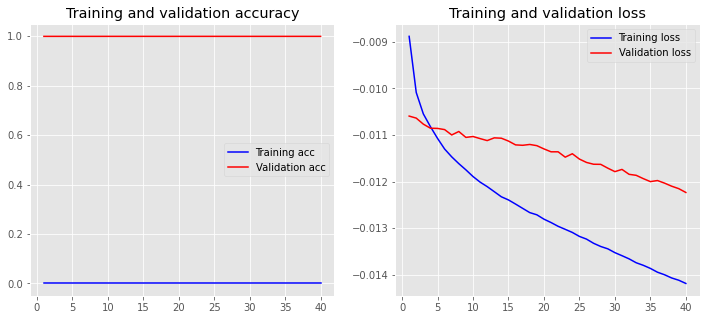

In [4]:
####PLOTS of loss and accuracy
# Plot the graph 
plt.style.use('ggplot')

def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

####FIT with the TEST data
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag_all[p_i])
        out.append(out_i)
    return out
test_pred = model.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

#####REPORT of the fit

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)

###Rest
TP = {}
TN = {}
FP = {}
FN = {}
for tag in tag2idx_all.keys():
    TP[tag] = 0
    TN[tag] = 0    
    FP[tag] = 0    
    FN[tag] = 0    

def accumulate_score_by_tag(gt, pred):
    """
    For each tag keep stats
    """
    if gt == pred:
        TP[gt] += 1
    elif gt != 'O' and pred == 'O':
        FN[gt] +=1
    elif gt == 'O' and pred != 'O':
        FP[gt] += 1
    else:
        TN[gt] += 1

for i, sentence in enumerate(X_test):
    y_hat = np.argmax(test_pred[0], axis=-1)
    gt = np.argmax(y_test[0], axis=-1)
    for idx, (w,pred) in enumerate(zip(sentence,y_hat)):
        accumulate_score_by_tag(idx2tag_all[gt[idx]],tags_all[pred])

for tag in tag2idx_all.keys():
    print(f'tag:{tag}')    
    print('\t TN:{:10}\tFP:{:10}'.format(TN[tag],FP[tag]))
    print('\t FN:{:10}\tTP:{:10}'.format(FN[tag],TP[tag]))

In [0]:
from google.colab import files
train.to_csv('train.csv')
dev.to_csv('dev.csv')
test.to_csv('test.csv')
train2.to_csv('train2.csv')

In [0]:
result_unstructured=pd.DataFrame({'Test Tag':test_labels,'Predicted Tag':pred_labels})
result_unstructured.to_csv('result_unstructured.csv')

test_tag_temp01=[[tag2idx_all[w[1]] for w in s] for s in sentences_test]
test_tag_ind01=[]
for i in range(len(test_tag_temp01)):
  test_tag_ind01.append(len(test_tag_temp01[i]))

predicted_tag_temp01=[]
for i in range(len(pred_labels)):
  predicted_tag_temp01.extend(pred_labels[i][:test_tag_ind01[i]])

result=test.assign(predicted_tag=predicted_tag_temp01)
result.to_csv('result.csv')